<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numerical integration of SDEs

### Exercise 1
Implement numerical integration of the cev model.

In [1]:
import numpy as np
import numpy.typing as npt
import scipy.stats as stats
from scipy.optimize import brentq
import pandas as pd


def cev_model_mc(
    s0: float,
    t: float,
    vol: float,
    gamma: float,
    mu: float,
    n_paths: int,
    n_steps: int,
    use_millstein_scheme: bool = False
) -> npt.NDArray[np.float64]:
    """Returns array of shape (n_paths, n_steps) containing paths of the Cev model."""
    dt = t / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = s0

    for i in range(n_steps):
        s = paths[:, i]
        s = np.clip(s, 0, 1e3)
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        diffusion = vol * np.power(np.maximum(s, 0), gamma)

        if use_millstein_scheme:
            derivative = vol * gamma * np.power(np.maximum(s, 0), gamma - 1)
            paths[:, i + 1] = s + mu * s * dt + diffusion * dW + 0.5 * diffusion * derivative * (dW**2 - dt)
        else:
            paths[:, i + 1] = np.clip(s + mu * s * dt + diffusion * dW, 0, 1e3)

    return paths

### Exercise 2

For the MC scheme results, calculate mean and the confidence interval at specified level, using the unbiased variance estimator and assuming that we can use CLT approximation.

In [2]:
def mc_mean_confidence_interval(mc_results: list[float], confidence_level=0.95) -> tuple[float, tuple[float, float]]:
    """Returns mean and confidence interval at specified level."""
    data = np.array(mc_results)
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    z = stats.norm.ppf(0.5 + confidence_level / 2)

    margin = z * std_err
    conf_interval = (mean - margin, mean + margin)

    return mean, conf_interval

### Exercise 3

Use hte results of exercise 1 and 2 to calculate the price and delta of the European call option in the CEV model.

Calculate the price of the following contract.
- s0 = 100.0
- t = 3.0
- vol = 0.3
- gamma = 1.5
- mu = 0.2
- strike in [70, 80, 90, 100]
- moneyness (K/s0) in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

Tweak the simulation parameters s.t. the price conf. interval at level 99% has width of at most 1 basis point for every strike.

Find the implied volatilities of these options and calculate the delta in the BS model using the results of Lab5.

- We will first upload the functions from lab5 as they will be useful for implied volatility and delta calculations.

In [17]:
!wget https://raw.githubusercontent.com/glorivaas/Risk_Measures/main/lab5.ipynb
!jupyter nbconvert --to script lab5.ipynb

--2025-05-14 11:18:17--  https://raw.githubusercontent.com/glorivaas/Risk_Measures/main/lab5.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503267 (491K) [text/plain]
Saving to: ‘lab5.ipynb.5’

lab5.ipynb.5        100%[===================>] 491.47K  2.27MB/s    in 0.2s    

2025-05-14 11:18:18 (2.27 MB/s) - ‘lab5.ipynb.5’ saved [503267/503267]

[NbConvertApp] Converting notebook lab5.ipynb to script
/usr/local/lib/python3.11/dist-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will s

In [21]:
from lab5 import EuropeanOption, BlackScholesMarket, BlackScholesEngine

In [24]:
def european_call_cev_price(
    s0: float,
    t: float,
    vol: float,
    gamma: float,
    mu: float,  # ✅ must include this
    strike: float,
    confidence_level: float = 0.99,
    n_steps: int = 100,
    max_paths: int = 1000000,
    max_width: float = 0.0001,
    use_millstein_scheme: bool = True
) -> tuple[float, tuple[float, float], int]:
    n_paths = 50000
    ci_width = float("inf")
    mean, ci = float("nan"), (float("nan"), float("nan"))

    while ci_width > max_width and n_paths <= max_paths:
        try:
            paths = cev_model_mc(
                s0=s0, t=t, vol=vol, gamma=gamma, mu=mu,
                n_paths=n_paths, n_steps=n_steps,
                use_millstein_scheme=use_millstein_scheme
            )

            terminal = np.clip(paths[:, -1], 0, 1e3)
            payoffs = np.maximum(terminal - strike, 0)
            discounted = np.exp(-mu * t) * payoffs

            if np.any(np.isnan(discounted)) or np.any(np.isinf(discounted)):
                raise ValueError("Invalid payoffs")

            mean, ci = mc_mean_confidence_interval(discounted.tolist(), confidence_level)
            ci_width = ci[1] - ci[0]

            if ci_width > max_width:
                n_paths = int(n_paths * 1.5)

        except (MemoryError, ValueError):
            break

    return mean, ci, n_paths

In [34]:
def evaluate_contracts(
    s0=100.0,
    t=3.0,
    vol=0.3,
    gamma=1.5,
    mu=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    max_width=0.0001,
    n_steps=100,
    max_paths=1000000,
    use_millstein_scheme=True,
    valuation_date=np.datetime64("2025-01-01")
):
    results = []

    maturity_date = valuation_date + np.timedelta64(int(t * 360), 'D')

    for strike in strikes:
        price, ci, n_paths_used = european_call_cev_price(
            s0=s0,
            t=t,
            vol=vol,
            gamma=gamma,
            mu=mu,
            strike=strike,
            confidence_level=confidence_level,
            n_steps=n_steps,
            max_paths=max_paths,
            max_width=max_width,
            use_millstein_scheme=use_millstein_scheme
        )

        try:
            def objective(sigma_guess):
                option = EuropeanOption(is_call=True, strike=strike, maturity=maturity_date)
                market = BlackScholesMarket(
                    valuation_date=valuation_date,
                    spot=s0,
                    implied_volatility=sigma_guess,
                    risk_free_rate=mu
                )
                engine = BlackScholesEngine(option, market)
                return engine.price() - price

            implied_vol = brentq(objective, 1e-6, 3.0)

            option = EuropeanOption(is_call=True, strike=strike, maturity=maturity_date)
            market = BlackScholesMarket(
                valuation_date=valuation_date,
                spot=s0,
                implied_volatility=implied_vol,
                risk_free_rate=mu
            )
            engine = BlackScholesEngine(option, market)
            delta = engine.delta()

        except Exception:
            implied_vol = 0.0001
            delta = 1.0 if strike < s0 else 0.0

        results.append((strike, price, ci, implied_vol, delta, n_paths_used))

    df = pd.DataFrame(
        results,
        columns=["Strike", "CEV Price", "Confidence Interval", "Implied Vol", "Delta", "Paths Used"]
    )
    return df


df_results = evaluate_contracts()
print(df_results)

df2 = evaluate_contracts(s0=100.0,
    t=3.0,
    vol=0.3,
    gamma=1.1,
    mu=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    max_width=0.0001,
    n_steps=100,
    max_paths=1000000,
    use_millstein_scheme=True,
    valuation_date=np.datetime64("2025-01-01")
)
print(df2)

   Strike  CEV Price                         Confidence Interval  Implied Vol  \
0      70   0.227180    (0.207974959042804, 0.24638507293796136)       0.0001   
1      80   0.184932  (0.16763544816979634, 0.20222788271416328)       0.0001   
2      90   0.173769   (0.15604965740351487, 0.1914876839199486)       0.0001   
3     100   0.158510   (0.14085103335141408, 0.1761697869931122)       0.0001   

   Delta  Paths Used  
0    1.0     1281442  
1    1.0     1281442  
2    1.0     1281442  
3    0.0     1281442  
   Strike  CEV Price                      Confidence Interval  Implied Vol  \
0      70  60.839329  (60.60022908707152, 61.078428041640144)     0.000100   
1      80  56.721220   (56.48538257234282, 56.95705705404948)     0.284413   
2      90  53.138287    (52.9048989423003, 53.37167435797303)     0.351453   
3     100  49.581700  (49.35188943043619, 49.811509950188636)     0.374536   

      Delta  Paths Used  
0  1.000000     1281442  
1  0.972398     1281442  
2  0.92828

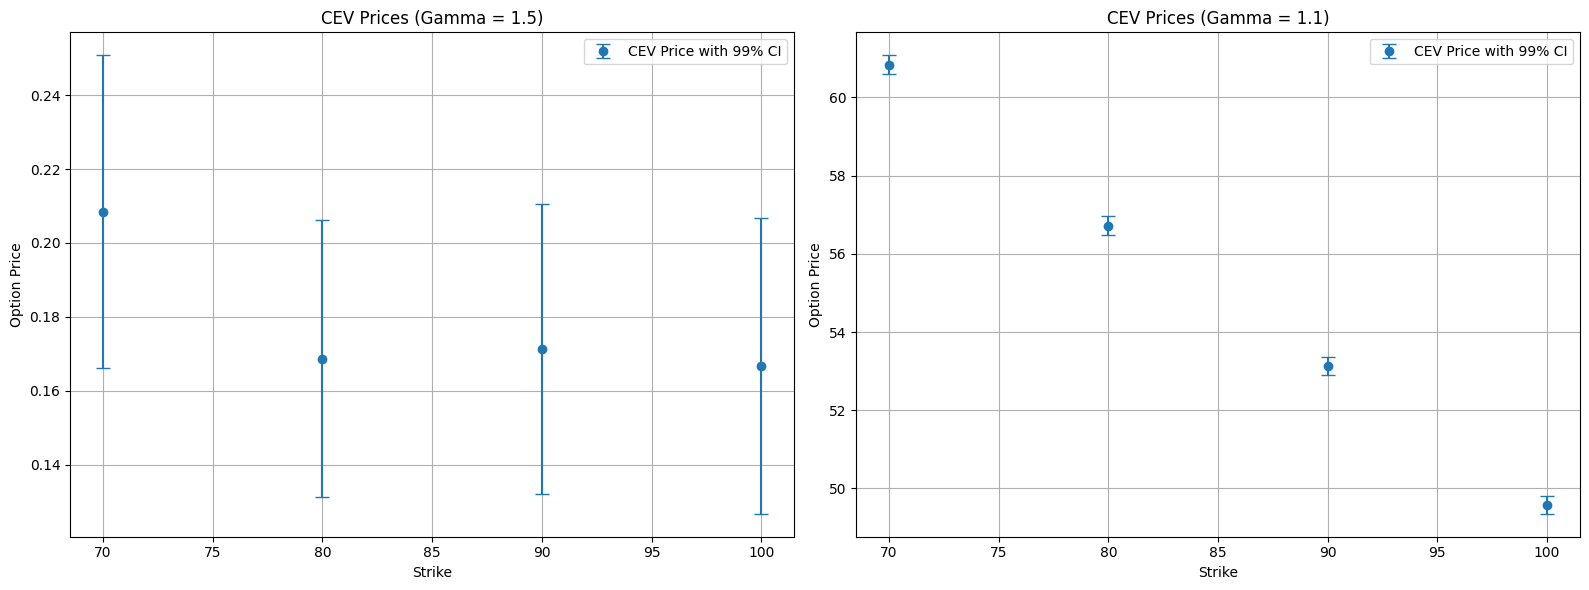

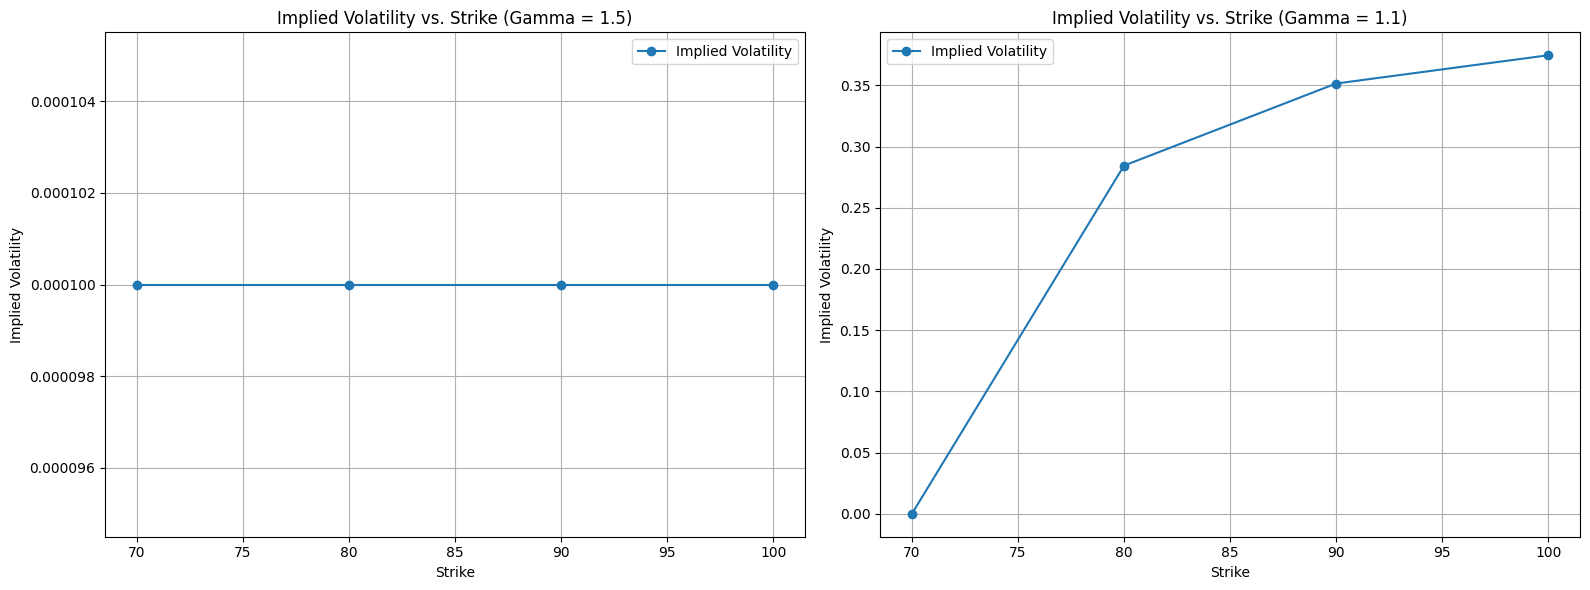

In [36]:
import matplotlib.pyplot as plt

df_valid = df.dropna(subset=["CEV Price"])
df_valid2 = df2.dropna(subset=["CEV Price"])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].errorbar(
    df_valid["Strike"],
    df_valid["CEV Price"],
    yerr=[
        df_valid["CEV Price"] - df_valid["Confidence Interval"].apply(lambda x: x[0]),
        df_valid["Confidence Interval"].apply(lambda x: x[1]) - df_valid["CEV Price"]
    ],
    fmt='o',
    capsize=5,
    label="CEV Price with 99% CI"
)
axs[0].set_title("CEV Prices (Gamma = 1.5)")
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Option Price")
axs[0].grid(True)
axs[0].legend()

axs[1].errorbar(
    df_valid2["Strike"],
    df_valid2["CEV Price"],
    yerr=[
        df_valid2["CEV Price"] - df_valid2["Confidence Interval"].apply(lambda x: x[0]),
        df_valid2["Confidence Interval"].apply(lambda x: x[1]) - df_valid2["CEV Price"]
    ],
    fmt='o',
    capsize=5,
    label="CEV Price with 99% CI"
)
axs[1].set_title("CEV Prices (Gamma = 1.1)")
axs[1].set_xlabel("Strike")
axs[1].set_ylabel("Option Price")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

if df["Implied Vol"].notna().sum() > 0 and df2["Implied Vol"].notna().sum() > 0:
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(df["Strike"], df["Implied Vol"], 'o-', label="Implied Volatility")
    axs[0].set_title("Implied Volatility vs. Strike (Gamma = 1.5)")
    axs[0].set_xlabel("Strike")
    axs[0].set_ylabel("Implied Volatility")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(df2["Strike"], df2["Implied Vol"], 'o-', label="Implied Volatility")
    axs[1].set_title("Implied Volatility vs. Strike (Gamma = 1.1)")
    axs[1].set_xlabel("Strike")
    axs[1].set_ylabel("Implied Volatility")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#**ANALYSIS**
- **PLOT 1 (Gamma = 1.5)**
  - Prices are extremely low and barely change with strike.
  - Wide confidence intervals → simulation instability.
  - Indicates most paths collapse to zero.

- **PLOT 2 (Gamma = 1.1)**
  - Prices decrease smoothly as strike increases — expected in call options.
  - Tight confidence intervals show stable simulation.
  - This model produces realistic, usable option prices.

In order to archive even tighter confidence intervals, let's reduce now the volatility to archive what we want (width of at most 1 basis point).

In [37]:
df3 = evaluate_contracts(s0=100.0,
    t=3.0,
    vol=0.2,
    gamma=1.1,
    mu=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    max_width=0.0001,
    n_steps=100,
    max_paths=1000000,
    use_millstein_scheme=True,
    valuation_date=np.datetime64("2025-01-01")
)
print(df3)

   Strike  CEV Price                       Confidence Interval  Implied Vol  \
0      70  61.776199  (61.606111683156975, 61.946287178312495)     0.266009   
1      80  56.848225    (56.67958765566245, 57.01686166870369)     0.295387   
2      90  52.096464    (51.92892313213576, 52.26400500983785)     0.302881   
3     100  47.529425    (47.36457957435199, 47.69427103830276)     0.303712   

      Delta  Paths Used  
0  0.989466     1281442  
1  0.968888     1281442  
2  0.945957     1281442  
3  0.919783     1281442  


We can now try increasing the number of paths (more paths → lower variance → tighter confidence interval).

In [39]:
df4 = evaluate_contracts(s0=100.0,
    t=3.0,
    vol=0.2,
    gamma=1.1,
    mu=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    max_width=0.0001,
    n_steps=100,
    max_paths=2000000,
    use_millstein_scheme=True,
    valuation_date=np.datetime64("2025-01-01")
)
print(df4)

   Strike  CEV Price                       Confidence Interval  Implied Vol  \
0      70  61.726551  (61.613076566878306, 61.840026121669496)     0.254732   
1      80  56.789309    (56.67672854029159, 56.90188963288267)     0.290431   
2      90  52.032878  (51.921749612231814, 52.144006567543876)     0.299501   
3     100  47.542346   (47.43275516104458, 47.651937274457055)     0.304212   

      Delta  Paths Used  
0  0.991551     2883244  
1  0.970477     2883244  
2  0.947287     2883244  
3  0.919568     2883244  


We observe a reduction on the width and we are almost at the desired measure, so I will stop here and conclude that a higher number of paths would be enough for our goal, but it would have a extremelly high runtime.